# Data Preprocessing

In [1]:
# Import Library and Data
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykrige.rk import Krige
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from pyproj import Transformer
from skgstat import Variogram
from scipy.stats import randint, uniform, loguniform

In [2]:
# Visualization function
def format_ax(ax, title, xlabel, ylabel, title_fontsize=18, label_fontsize=14):
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
    ax.tick_params(axis='x', rotation=45)

In [3]:
# 1) 재현성 확보
seed = 42
random.seed(seed)
np.random.seed(seed)

In [4]:
# Load Data
data = 'AlNiFe_data2.csv'
df = pd.read_csv('AlNiFe_data2.csv')

# 종속변수 및 조건변수 분리
y = df['AL'].values.astype(np.float32)

# 원-핫 인코딩
df_onehot = pd.get_dummies(df, columns=['LITHOIDX'])
cond = df_onehot.drop(['AL','FE','NI'], axis=1)

# Define independent and dependent variables
lon = np.array(df['X_utm'])
lat = np.array(df['Y_utm'])
coor = np.column_stack((lon, lat))

In [5]:
plt.rcParams['font.family'] = 'Arial'

In [6]:
# Train/Val/Test 분할 (70%/20%/10%)
X_train, X_temp, y_train, y_temp = train_test_split(cond, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test    = train_test_split(X_temp, y_temp, test_size=1/3, random_state=seed)

coor_train = np.column_stack((X_train['X_utm'], X_train['Y_utm']))
coor_val = np.column_stack((X_val['X_utm'], X_val['Y_utm']))
coor_test = np.column_stack((X_test['X_utm'], X_test['Y_utm']))

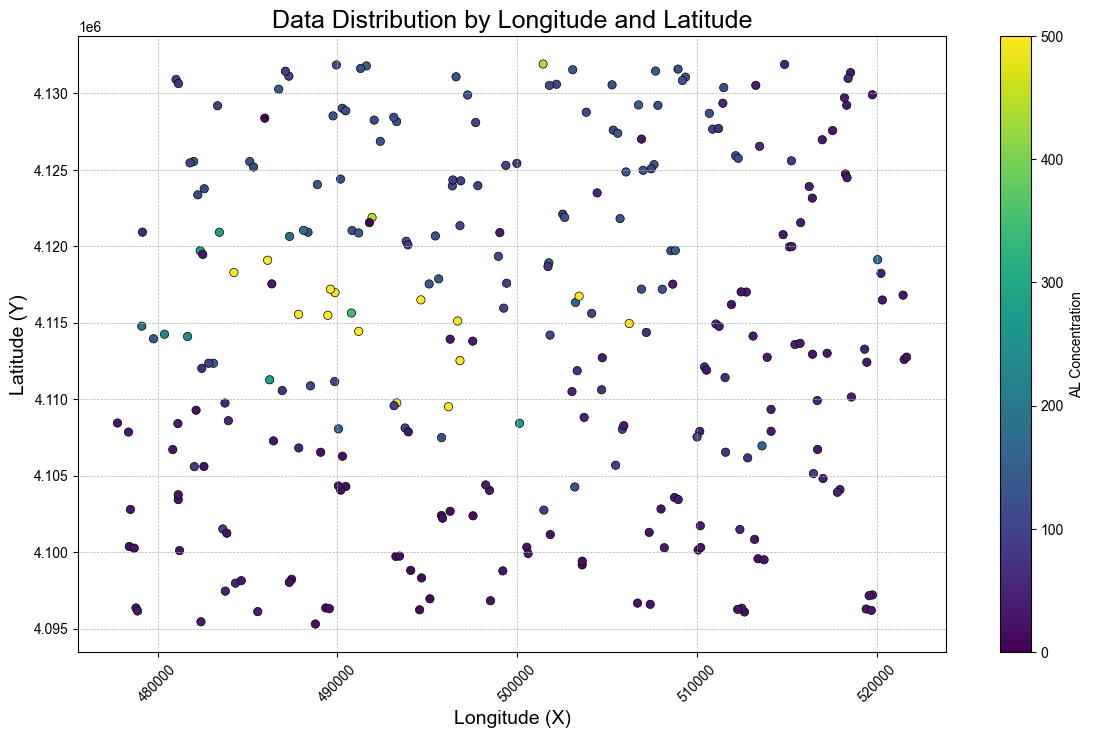

In [7]:
# Visualization of entire data distribution
fig, ax = plt.subplots(figsize=(14, 8))
sc = ax.scatter(coor[:, 0], coor[:, 1], c=y, cmap='viridis', edgecolor='k', linewidths=0.5)
format_ax(ax, 'Data Distribution by Longitude and Latitude', 'Longitude (X)', 'Latitude (Y)')
fig.colorbar(sc, ax=ax, label='AL Concentration')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

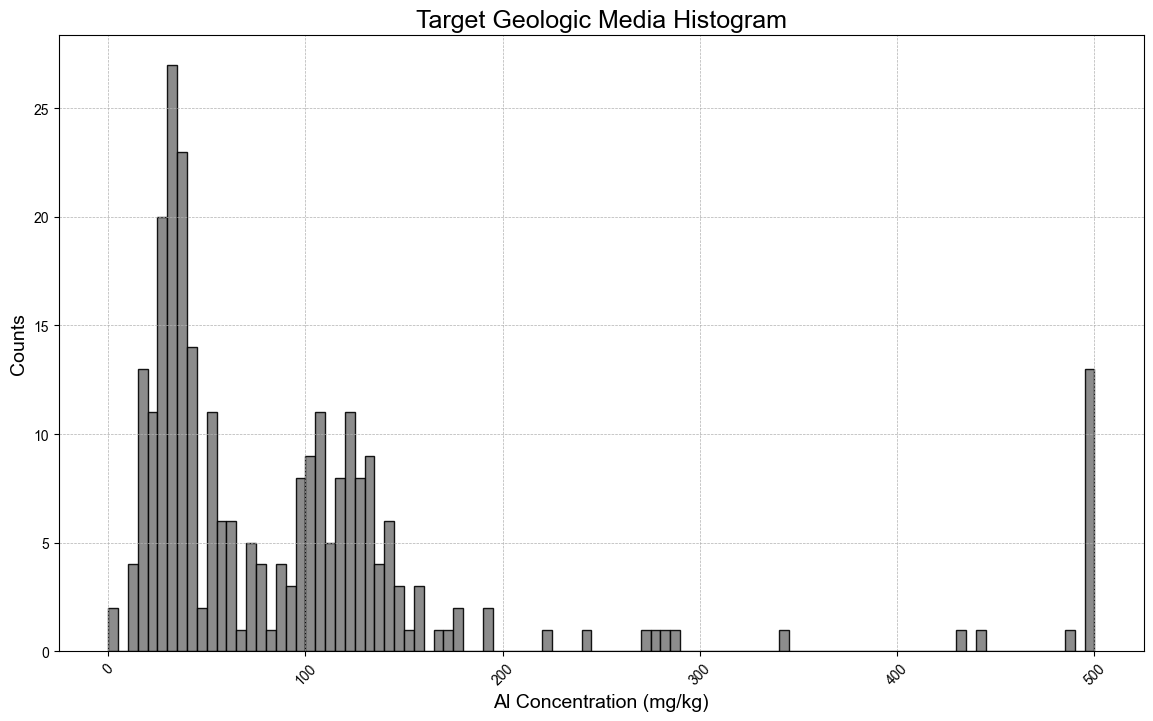

In [8]:
# Visualization of entire data histogram
fig, ax = plt.subplots(figsize=(14, 8))
sc = ax.hist(y, bins=100, color='grey', edgecolor='k', alpha=0.9)
format_ax(ax, 'Target Geologic Media Histogram', 'Al Concentration (mg/kg)', 'Counts')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [9]:
# 데이터 통계량 계산
al_mean = np.mean(y)
al_min = np.min(y)
al_max = np.max(y)
al_variance = np.var(y)

print(f"Mean of AL: {al_mean}")
print(f"Min of AL: {al_min}")
print(f"Max of AL: {al_max}")
print(f"Variance of AL: {al_variance}")

# Nugget과 Sill 값 설정
sill = al_variance * 1.1
nugget = sill * 0.1
x_range = np.max(coor[:, 0]) - np.min(coor[:, 0])  # 경도 범위
suggested_range = x_range / 2

print(f"{{'sill': {sill}, 'nugget': {nugget}, 'range': {suggested_range}}},")

# ±10%, ±20%, ±30% 계산
for pct in (10, 20, 30):
    up   = 1 + pct/100
    down = 1 - pct/100
    sill_up    = sill   * up
    sill_down  = sill   * down
    nugget_up  = nugget * up
    nugget_down= nugget * down
    range_up   = suggested_range * up
    range_down = suggested_range * down
    
    print(f"{{'sill': {sill_up}, 'nugget': {nugget_up}, 'range': {range_up}}},  # +{pct}%")
    print(f"{{'sill': {sill_down}, 'nugget': {nugget_down}, 'range': {range_down}}},  # -{pct}%")

Mean of AL: 100.76103210449219
Min of AL: 0.0
Max of AL: 500.0
Variance of AL: 12550.2109375
{'sill': 13805.232421875, 'nugget': 1380.5233154296875, 'range': 21930.604150000203},
{'sill': 15185.755859375, 'nugget': 1518.57568359375, 'range': 24123.664565000225},  # +10%
{'sill': 12424.708984375, 'nugget': 1242.470947265625, 'range': 19737.543735000185},  # -10%
{'sill': 16566.279296875, 'nugget': 1656.6280517578125, 'range': 26316.724980000243},  # +20%
{'sill': 11044.1865234375, 'nugget': 1104.418701171875, 'range': 17544.483320000163},  # -20%
{'sill': 17946.80078125, 'nugget': 1794.6802978515625, 'range': 28509.785395000265},  # +30%
{'sill': 9663.662109375, 'nugget': 966.3663330078125, 'range': 15351.422905000141},  # -30%


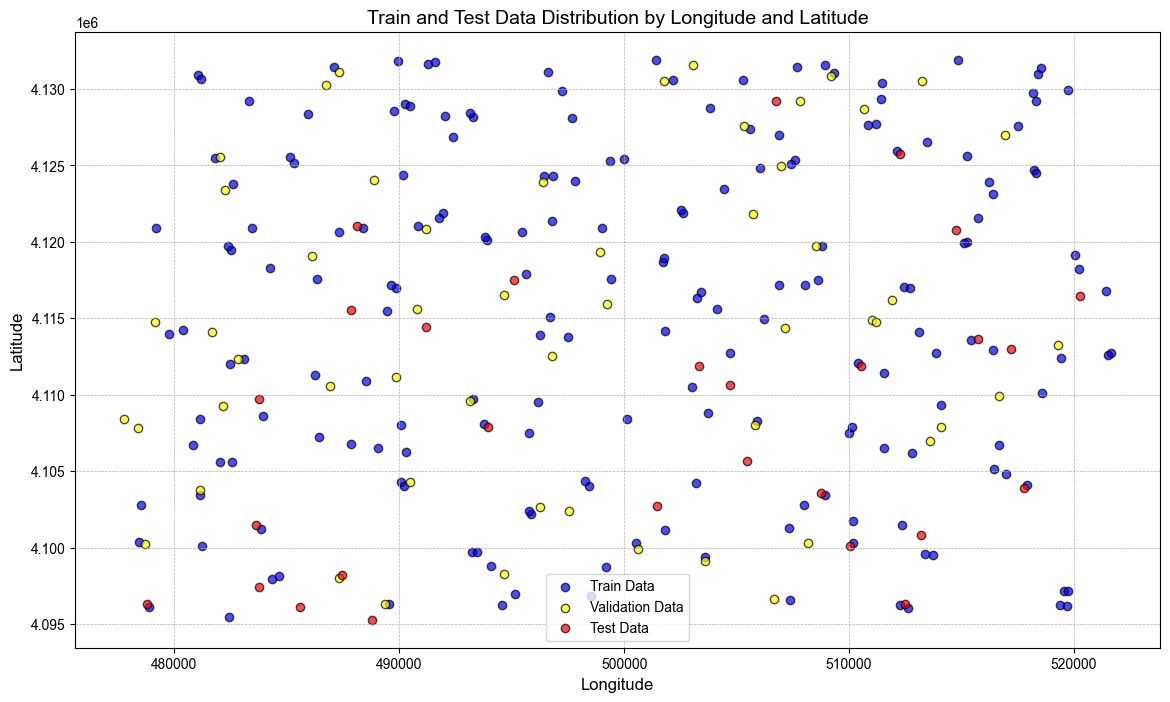

In [10]:
# Train과 Test 데이터를 산포도로 시각화
plt.figure(figsize=(14, 8))

# 학습 데이터 산포도 (파란색)
plt.scatter(X_train['X_utm'], X_train['Y_utm'], color='blue', label='Train Data', alpha=0.7, edgecolor='k')

# 검증 데이터 산포도 (노란색)
plt.scatter(X_val['X_utm'], X_val['Y_utm'], color='yellow', label='Validation Data', alpha=0.7, edgecolors='k')

# 테스트 데이터 산포도 (빨간색)
plt.scatter(X_test['X_utm'], X_test['Y_utm'], color='red', label='Test Data', alpha=0.7, edgecolor='k')

# 축 및 제목 설정
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Train and Test Data Distribution by Longitude and Latitude', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [11]:
# Grid for Prediction
x_grid = np.linspace(min(coor[:, 0]), max(coor[:, 0]), 100)
y_grid = np.linspace(min(coor[:, 1]), max(coor[:, 1]), 100)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

## scikit-gstat의 Variogram을 통한 경험적 베리오그램 계산

In [12]:
V1 = Variogram(coordinates=coor, values=y, model='spherical', n_lags=10)
V2 = Variogram(coordinates=coor, values=y, model='exponential', n_lags=10)
V3 = Variogram(coordinates=coor, values=y, model='gaussian', n_lags=10)

In [13]:
V1.parameters, V2.parameters, V3.parameters

([np.float64(8360.09455956309), np.float64(9521.394204180291), 0],
 [np.float64(6665.766020567875), np.float64(9452.925356557595), 0],
 [np.float64(7962.824443483238), np.float64(9516.683576861164), 0])

# Ordinary Kriging 적용(StandardScaler 변환)

In [14]:
# "ordinary" Kriging에 대한 파라미터 그리드
param_dist_ordinary = {
    "method":             ["ordinary"],
    "variogram_model":    ["spherical", "exponential", "gaussian"],
    "variogram_parameters":[
{'sill': 9521.394204180291, 'nugget': 0, 'range': 8360.09455956309},
{'sill': 9452.92538775293, 'nugget': 0, 'range': 6665.767202520162},
{'sill': 9516.683550481837, 'nugget': 0, 'range': 7962.824149722335},  
    ],
    "nlags":              randint(2, 31),
    "weight":             [True, False],
    "coordinates_type":   ["euclidean", "geographic"],
    "n_closest_points":   randint(2, 31),
    "exact_values":       [True, False],
}

In [15]:
# 2) Krige 모델 초기화
model_ok = Krige()

In [16]:
# 3) RandomizedSearchCV 설정
rand_search_ok = RandomizedSearchCV(
    estimator           = model_ok,
    param_distributions = param_dist_ordinary,
    n_iter              = 50,    # 랜덤 조합 시도 횟수
    cv                  = 5,
    scoring             = 'neg_mean_squared_error',
    verbose             = 1,
    n_jobs               = -1,
    random_state        = 42
)

# 4) 학습
try:
    rand_search_ok.fit(coor_train, y_train)
except ValueError as e:
    print(f"Error during fitting: {e}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [17]:
# 5) 결과 확인
print("Best params (OK):", rand_search_ok.best_params_)
print("Best CV RMSE (OK):", np.sqrt(-rand_search_ok.best_score_))

Best params (OK): {'coordinates_type': 'euclidean', 'exact_values': False, 'method': 'ordinary', 'n_closest_points': 16, 'nlags': 4, 'variogram_model': 'exponential', 'variogram_parameters': {'sill': 9521.394204180291, 'nugget': 0, 'range': 8360.09455956309}, 'weight': False}
Best CV RMSE (OK): 108.57325214708725



Best parameters found (Ordinary Kriging):
coordinates_type: euclidean
exact_values: False
method: ordinary
n_closest_points: 16
nlags: 4
variogram_model: exponential
variogram_parameters: {'sill': 9521.394204180291, 'nugget': 0, 'range': 8360.09455956309}
weight: False
Best MSE (Ordinary Kriging): 11788.1511
Best RMSE (Ordinary Kriging): 108.5733
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 9521.394204180291
Full Sill: 9521.394204180291
Range: 8360.09455956309
Nugget: 0 



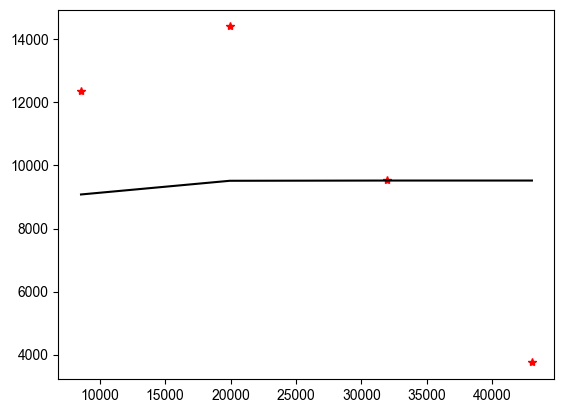

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Validation RMSE (Ordinary Kriging): 100.90
Validation R² (Ordinary Kriging): 0.208
Executing Ordinary Kriging...


Ordinary Kriging grid prediction completed successfully


In [18]:
# RandomizedSearchCV 결과
if hasattr(rand_search_ok, 'best_params_'):
    best_params_ordinary = rand_search_ok.best_params_
    best_score_ordinary = rand_search_ok.best_score_
    if best_score_ordinary is not None and not np.isnan(best_score_ordinary):
        best_mse_ordinary = abs(best_score_ordinary)
        best_rmse_ordinary = np.sqrt(best_mse_ordinary)

        print("\nBest parameters found (Ordinary Kriging):")
        for param, value in best_params_ordinary.items():
            print(f"{param}: {value}")
        print(f"Best MSE (Ordinary Kriging): {best_mse_ordinary:.4f}")
        print(f"Best RMSE (Ordinary Kriging): {best_rmse_ordinary:.4f}")

    # 검증 데이터셋에 대해 Ordinary Kriging 모델 생성
    ok_model = OrdinaryKriging(
        coor_train[:, 0], coor_train[:, 1], y_train,
        variogram_model    = best_params_ordinary['variogram_model'],
        variogram_parameters = best_params_ordinary.get('variogram_parameters', None),
        nlags              = best_params_ordinary['nlags'],
        weight             = best_params_ordinary['weight'],
        verbose            = True,
        enable_plotting    = True,
        coordinates_type   = best_params_ordinary['coordinates_type'],
        exact_values       = best_params_ordinary['exact_values']
    )

    # 1) 검증 데이터에 대한 예측
    try:
        z_pred_val, _ = ok_model.execute(
            'points',
            coor_val[:, 0], coor_val[:, 1]
        )
        
        rmse_val_ok = np.sqrt(mean_squared_error(y_val, z_pred_val))
        r2_val_ok   = r2_score(y_val, z_pred_val)
        print(f"Validation RMSE (Ordinary Kriging): {rmse_val_ok:.2f}")
        print(f"Validation R² (Ordinary Kriging): {r2_val_ok:.3f}")

    except Exception as e:
        print(f"\nError during Ordinary Kriging prediction on validation data: {e}\n")

    # 2) 전체 그리드에 대한 예측
    try:
        z_pred_grid_ok, ok_ss = ok_model.execute(
            'grid', x_grid, y_grid
        )
        print("\nOrdinary Kriging grid prediction completed successfully")
    except Exception as e:
        print(f"\nError during Ordinary Kriging grid prediction: {e}")

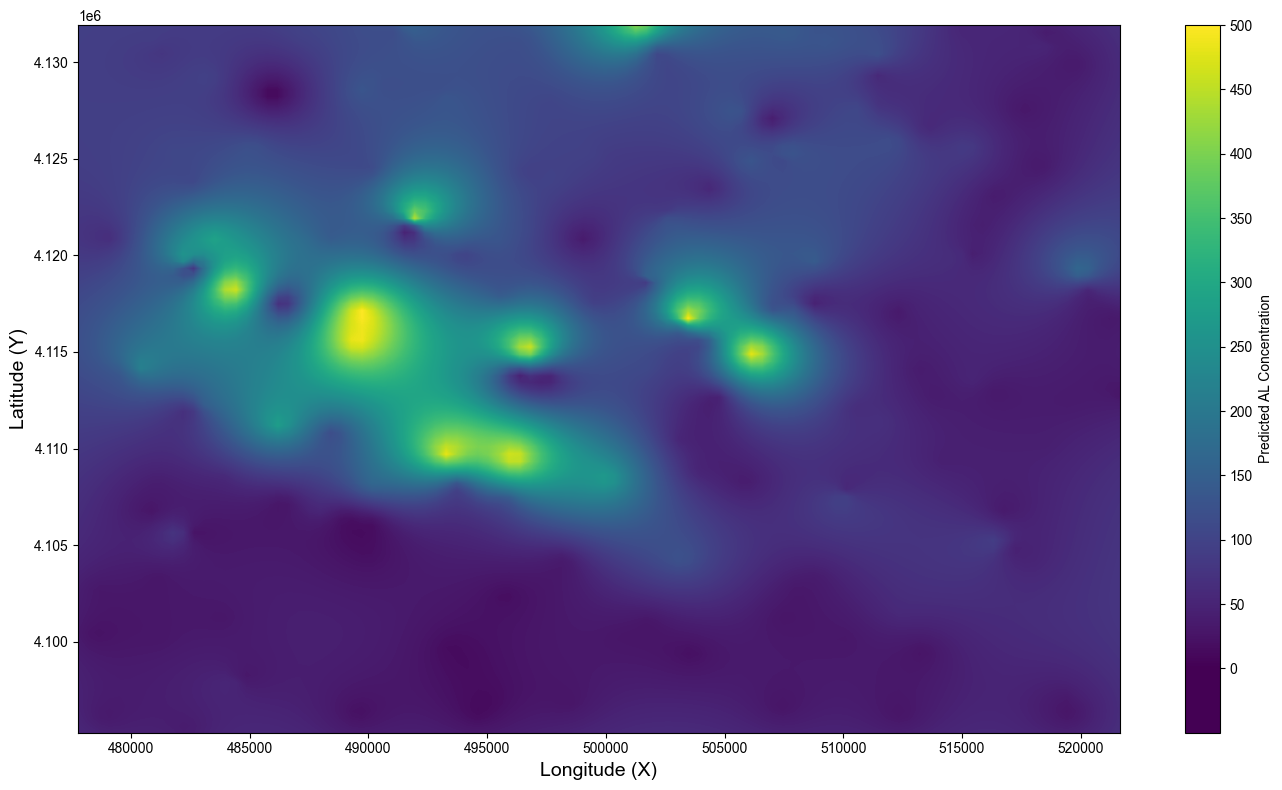

In [19]:
# Visualization of Ordinary Kriging Predictions
fig, ax = plt.subplots(figsize=(14, 8))
c = ax.contourf(x_mesh, y_mesh, z_pred_grid_ok, levels=np.linspace(-50, 500, 551), cmap='viridis', vmin=0, vmax=500)
ax.set_xlabel('Longitude (X)', fontsize=14)
ax.set_ylabel('Latitude (Y)', fontsize=14)
#ax.set_title('Ordinary Kriging', fontsize=18)
cbar = fig.colorbar(c, ax=ax, label='Predicted AL Concentration')
cbar.set_ticks(np.linspace(0, 500, 11))
plt.tight_layout()
plt.show()

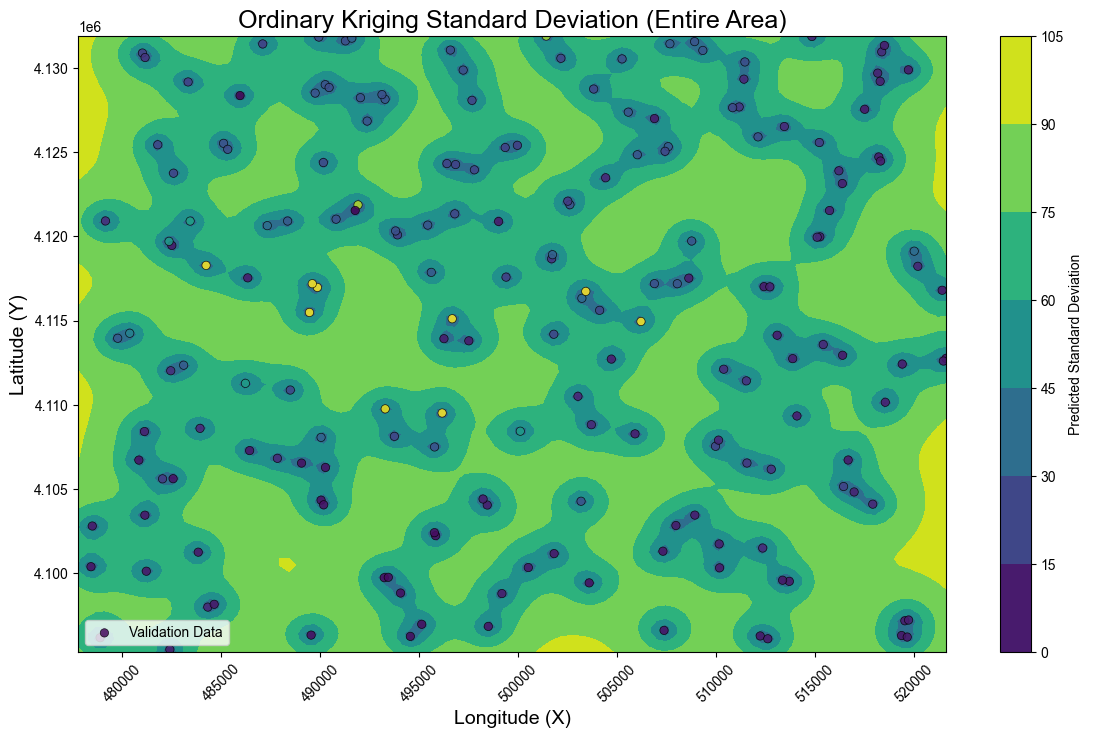

In [20]:
# Visualization of Ordinary Kriging Standard Deviation
fig, ax = plt.subplots(figsize=(14, 8))
std_ok = np.sqrt(ok_ss)
c = ax.contourf(x_mesh, y_mesh, std_ok, cmap='viridis')
ax.scatter(coor_train[:, 0], coor_train[:, 1], c=y_train, label='Validation Data', alpha=0.85, edgecolor='k', linewidth=0.5)
format_ax(ax, 'Ordinary Kriging Standard Deviation (Entire Area)', 'Longitude (X)', 'Latitude (Y)')
ax.legend()
fig.colorbar(c, ax=ax, label='Predicted Standard Deviation')
#cbar.set_ticks(np.linspace(30, 60, 13))
plt.show()

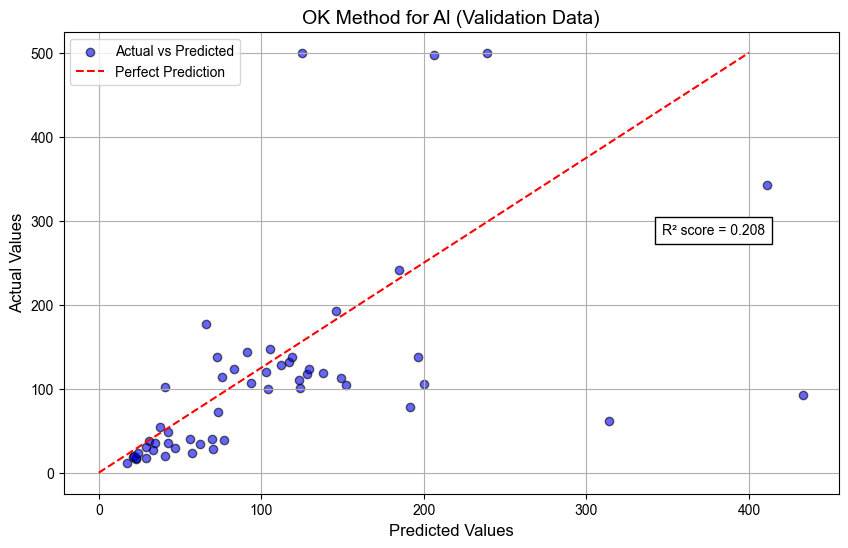

In [21]:
# 산점도 시각화
plt.figure(figsize=(10, 6)) 
plt.scatter(z_pred_val, y_val, color='blue', edgecolor='k', alpha=0.6, label='Actual vs Predicted')
plt.plot([0, 400], [0, 500], 'r--', label='Perfect Prediction')

# 텍스트 위치 설정
x_text = max(z_pred_val) * 0.8  
y_text = min(z_pred_val) + (max(z_pred_val) - min(z_pred_val)) * 0.64 
plt.text(x_text, y_text, f'R² score = {r2_val_ok:.3f}', color='black',
         bbox=dict(facecolor='w', edgecolor='black', boxstyle='square,pad=0.5'))

plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Actual Values', fontsize=12)
plt.title('OK Method for Al (Validation Data)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

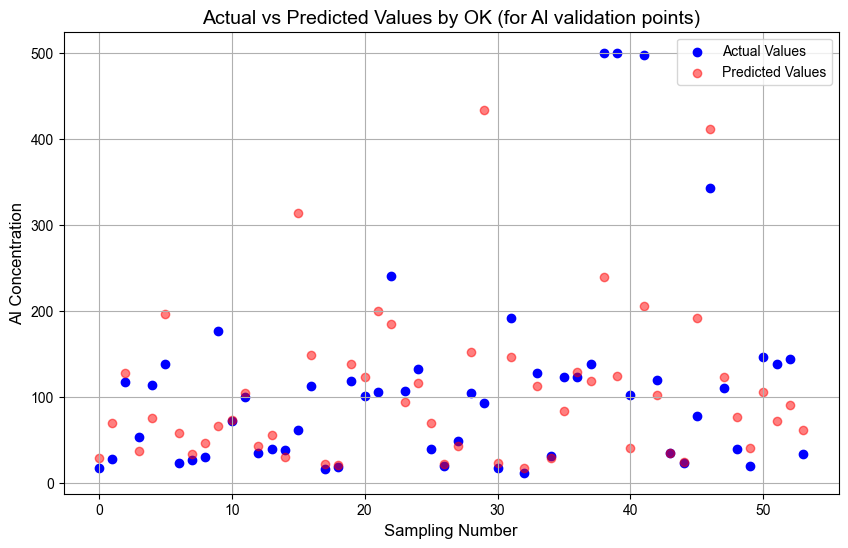

In [22]:
# 샘플링 순서에 따른 실제 값과 예측 값 비교
plt.figure(figsize=(10, 6))

# 검증 데이터에 대한 샘플 순서 번호 생성
observation_value = np.arange(len(y_val))

# 실제 값 플롯
plt.scatter(observation_value, y_val, label='Actual Values', color='blue')

# 예측 값 플롯
plt.scatter(observation_value, z_pred_val, label='Predicted Values', color='red', alpha=0.5)

plt.xlabel('Sampling Number', fontsize=12)
plt.ylabel('Al Concentration', fontsize=12)
plt.title('Actual vs Predicted Values by OK (for Al validation points)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# 테스트 데이터셋에 대한 예측 수행
try:
    z_pred_test, _ = ok_model.execute('points', coor_test[:, 0], coor_test[:, 1])

    # RMSE 및 R2 계산 (원래 스케일로 복원된 값 사용)
    rmse_test_ok = np.sqrt(mean_squared_error(y_test, z_pred_test))
    mae_test_ok = mean_absolute_error(y_test, z_pred_test)
    r2_test_ok = r2_score(y_test, z_pred_test)

    print(f"Test RMSE (Ordinary Kriging): {rmse_test_ok:.2f}")
    print(f"Test MAE (Ordinary Kriging): {mae_test_ok:.2f}")
    print(f"Test R2 (Ordinary Kriging): {r2_test_ok:.3f}")

except Exception as e:
    print(f"\nError during Ordinary Kriging prediction on test data: {e}\n")

Executing Ordinary Kriging...

Test RMSE (Ordinary Kriging): 53.65
Test MAE (Ordinary Kriging): 32.15
Test R2 (Ordinary Kriging): 0.803


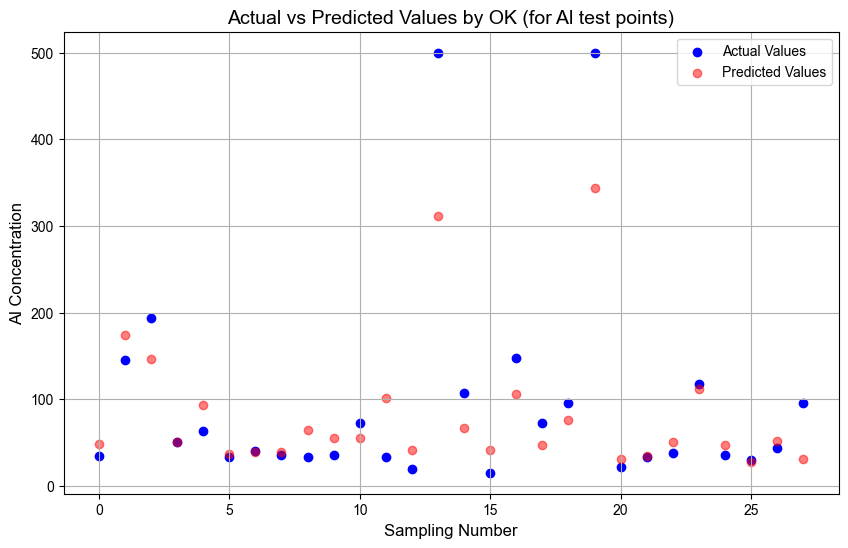

In [24]:
# 샘플링 순서에 따른 실제 값과 예측 값 비교
plt.figure(figsize=(10, 6))

# 검증 데이터에 대한 샘플 순서 번호 생성
observation_value = np.arange(len(y_test))

# 실제 값 플롯
plt.scatter(observation_value, y_test, label='Actual Values', color='blue')

# 예측 값 플롯
plt.scatter(observation_value, z_pred_test, label='Predicted Values', color='red', alpha=0.5)

plt.xlabel('Sampling Number', fontsize=12)
plt.ylabel('Al Concentration', fontsize=12)
plt.title('Actual vs Predicted Values by OK (for Al test points)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Universal Kriging 적용(StandardScaler 변환)

In [25]:
# 1) 하이퍼파라미터 분포 정의
param_dist_universal = {
    "method": ["universal"],
    "variogram_model":    ["spherical", "exponential", "gaussian"],
    "variogram_parameters":[
{'sill': 9521.394204180291, 'nugget': 0, 'range': 8360.09455956309},
{'sill': 9452.92538775293, 'nugget': 0, 'range': 6665.767202520162},
{'sill': 9516.683550481837, 'nugget': 0, 'range': 7962.824149722335},  
    ],
    "nlags": randint(2, 31),
    "weight": [True, False],
    "coordinates_type": ["euclidean", "geographic"],
    "drift_terms": [None, "regional_linear"],
    "exact_values": [True, False]
}

In [26]:
# Krige 모델 초기화
model_uk = Krige()

In [27]:
# 3) RandomizedSearchCV 설정
rand_search_uk = RandomizedSearchCV(
    estimator           = model_uk,
    param_distributions = param_dist_universal,
    n_iter              = 50,      # 50회 무작위 탐색
    cv                  = 5,
    scoring             = 'neg_mean_squared_error',
    verbose             = 1,
    n_jobs              = -1,
    random_state        = 42
)

# 4) 학습
try:
    rand_search_uk.fit(coor_train, y_train)
except ValueError as e:
    print(f"Error encountered during fitting: {e}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [28]:
# 결과 확인
print("Best params (UK):", rand_search_uk.best_params_)
print("Best CV RMSE (UK):", np.sqrt(-rand_search_uk.best_score_))

Best params (UK): {'coordinates_type': 'geographic', 'drift_terms': None, 'exact_values': False, 'method': 'universal', 'nlags': 15, 'variogram_model': 'exponential', 'variogram_parameters': {'sill': 9452.92538775293, 'nugget': 0, 'range': 6665.767202520162}, 'weight': True}
Best CV RMSE (UK): 105.92224621007503



Best parameters found (Universal Kriging):
  coordinates_type: geographic
  drift_terms: None
  exact_values: False
  method: universal
  nlags: 15
  variogram_model: exponential
  variogram_parameters: {'sill': 9452.92538775293, 'nugget': 0, 'range': 6665.767202520162}
  weight: True
Best MSE (Universal Kriging): 11219.5222
Best RMSE (Universal Kriging): 105.9222
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'exponential' Variogram Model
Partial Sill: 9452.92538775293
Full Sill: 9452.92538775293
Range: 6665.767202520162
Nugget: 0 



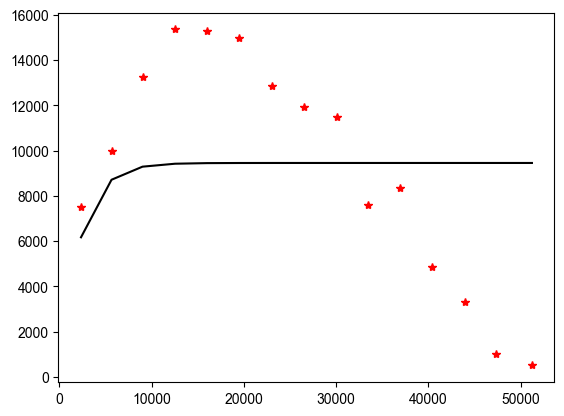

Calculating statistics on variogram model fit...
Q1 = 0.029094864830331666
Q2 = 1.8649129206844965
cR = 11644.223252628857 

Initializing drift terms...
Executing Universal Kriging...

Validation RMSE (Universal Kriging): 101.51
Validation R²  (Universal Kriging): 0.198
Executing Universal Kriging...


Universal Kriging grid prediction completed successfully


In [29]:
# 5) 최적 파라미터 수집 및 예측
if hasattr(rand_search_uk, 'best_params_'):
    best_params_universal = rand_search_uk.best_params_
    best_score_universal  = rand_search_uk.best_score_
    if best_score_universal is not None and not np.isnan(best_score_universal):
        best_mse_universal  = abs(best_score_universal)
        best_rmse_universal = np.sqrt(best_mse_universal)

        print("\nBest parameters found (Universal Kriging):")
        for param, value in best_params_universal.items():
            print(f"  {param}: {value}")
        print(f"Best MSE (Universal Kriging): {best_mse_universal:.4f}")
        print(f"Best RMSE (Universal Kriging): {best_rmse_universal:.4f}")

    # 6) UniversalKriging 모델 생성
    uk_model = UniversalKriging(
        coor_train[:,0], coor_train[:,1], y_train,
        variogram_model     = best_params_universal['variogram_model'],
        variogram_parameters= best_params_universal.get('variogram_parameters', None),
        nlags               = best_params_universal['nlags'],
        weight              = best_params_universal['weight'],
        drift_terms         = best_params_universal.get('drift_terms', None),
        verbose             = True,
        enable_plotting     = True,
#        coordinates_type    = best_params_universal['coordinates_type'],
        exact_values        = best_params_universal['exact_values']
    )

    # 7) 검증 데이터에 대한 예측
    try:
        z_val_uk, _ = uk_model.execute(
            'points', 
            coor_val[:, 0], coor_val[:, 1]
        )

        rmse_val_uk = np.sqrt(mean_squared_error(y_val, z_val_uk))
        r2_val_uk   = r2_score(y_val, z_val_uk)
        print(f"Validation RMSE (Universal Kriging): {rmse_val_uk:.2f}")
        print(f"Validation R²  (Universal Kriging): {r2_val_uk:.3f}")

    except Exception as e:
        print(f"\nError during Universal Kriging prediction on validation data: {e}")

    # 8) 전체 그리드 예측
    try:
        z_grid_uk, uk_ss = uk_model.execute('grid', x_grid, y_grid)
        print("\nUniversal Kriging grid prediction completed successfully")
    except Exception as e:
        print(f"\nError during Universal Kriging grid prediction: {e}")

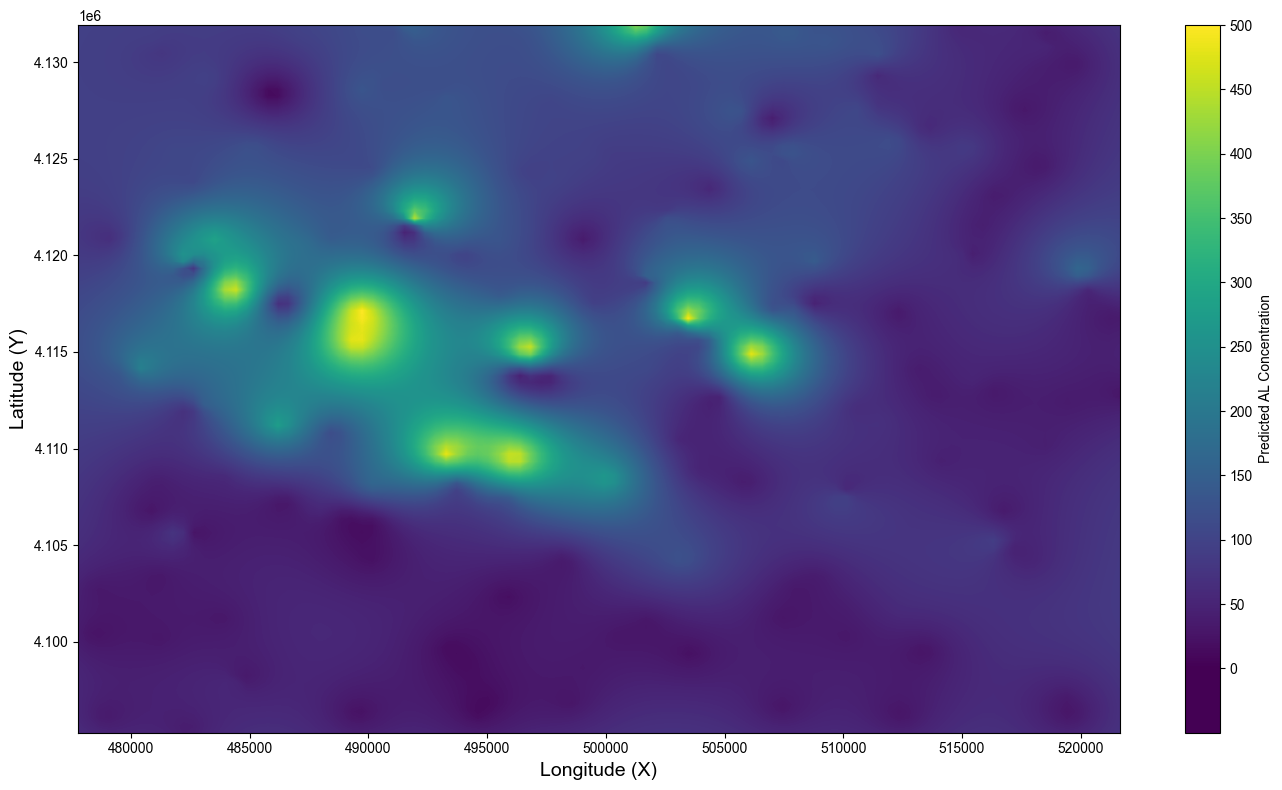

In [30]:
# Visualization of Universal Kriging Predictions
fig, ax = plt.subplots(figsize=(14, 8))
c = ax.contourf(x_mesh, y_mesh, z_grid_uk, levels=np.linspace(-50, 500, 551), cmap='viridis', vmin=0, vmax=500)
ax.set_xlabel('Longitude (X)', fontsize=14)
ax.set_ylabel('Latitude (Y)', fontsize=14)
#ax.set_title('Universal Kriging', fontsize=18)
cbar = fig.colorbar(c, ax=ax, label='Predicted AL Concentration')
cbar.set_ticks(np.linspace(0, 500, 11))
plt.tight_layout()
plt.show()

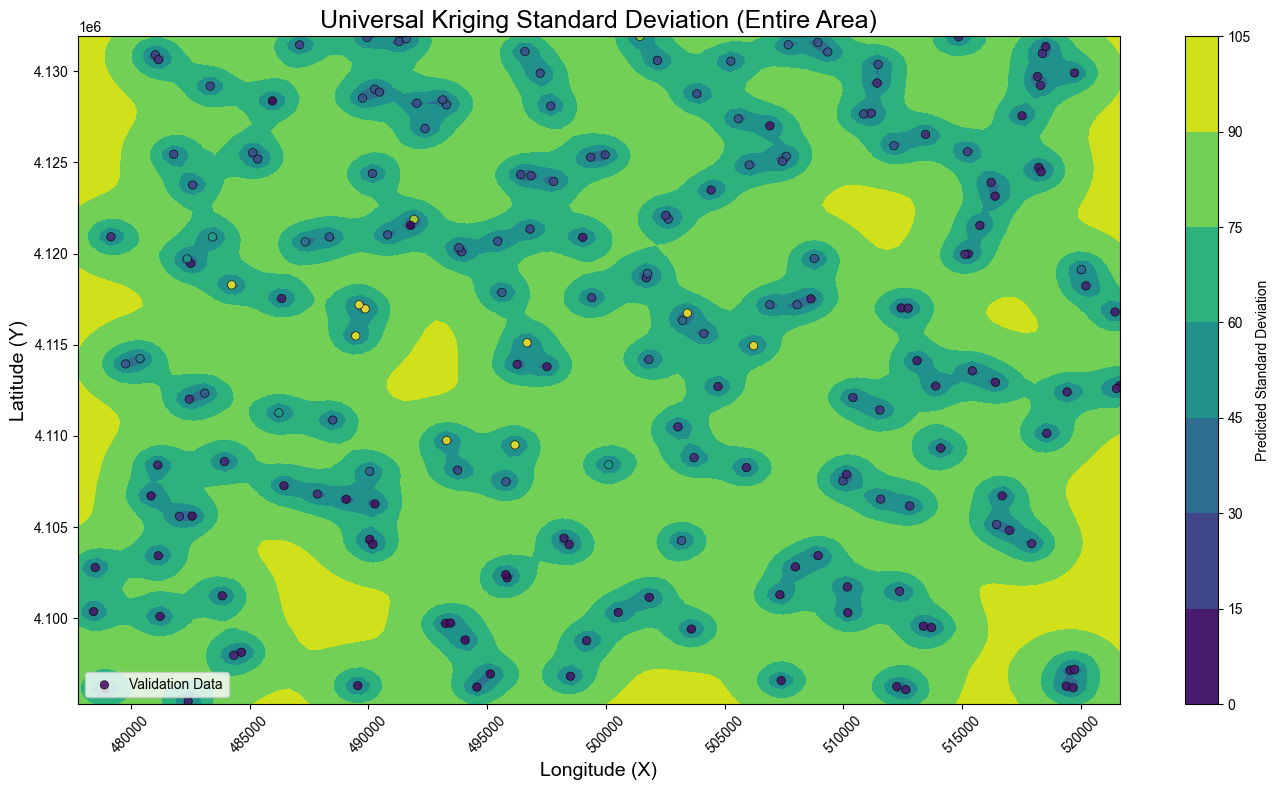

In [31]:
# Visualization of Universal Kriging Standard Deviation
fig, ax = plt.subplots(figsize=(14, 8))
std_uk = np.sqrt(uk_ss)
c = ax.contourf(x_mesh, y_mesh, std_uk, cmap='viridis')
ax.scatter(coor_train[:, 0], coor_train[:, 1], c=y_train, label='Validation Data', alpha=0.85, edgecolor='k', linewidth=0.5)
format_ax(ax, 'Universal Kriging Standard Deviation (Entire Area)', 'Longitude (X)', 'Latitude (Y)')
ax.legend()
fig.colorbar(c, ax=ax, label='Predicted Standard Deviation')
#cbar.set_ticks(np.linspace(30, 60, 13))
plt.tight_layout()
plt.show()

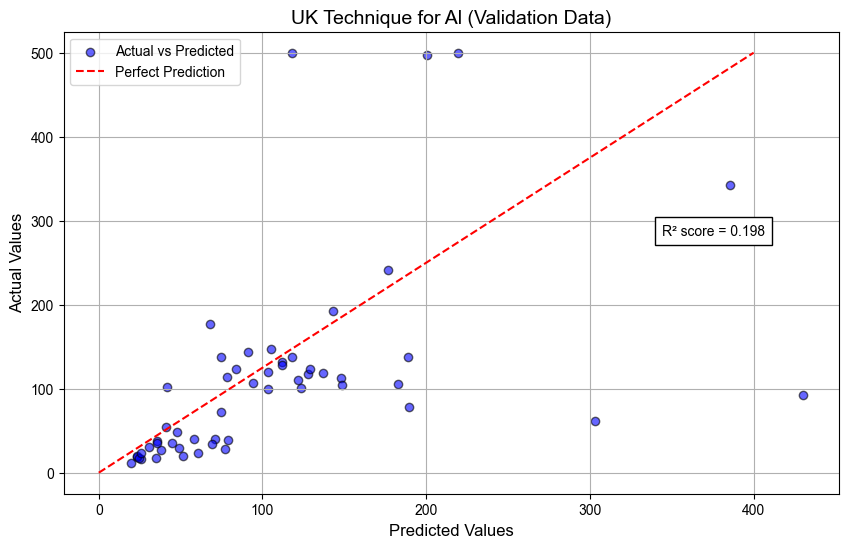

In [32]:
# 산점도 시각화
plt.figure(figsize=(10, 6)) 
plt.scatter(z_val_uk, y_val, color='blue', edgecolor='k', alpha=0.6, label='Actual vs Predicted')
plt.plot([0, 400], [0, 500], 'r--', label='Perfect Prediction')

# 텍스트 위치 설정
x_text = max(z_val_uk) * 0.8  
y_text = min(z_val_uk) + (max(z_val_uk) - min(z_val_uk)) * 0.64 
plt.text(x_text, y_text, f'R² score = {r2_val_uk:.3f}', color='black',
         bbox=dict(facecolor='w', edgecolor='black', boxstyle='square,pad=0.5'))

plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Actual Values', fontsize=12)
plt.title('UK Technique for Al (Validation Data)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

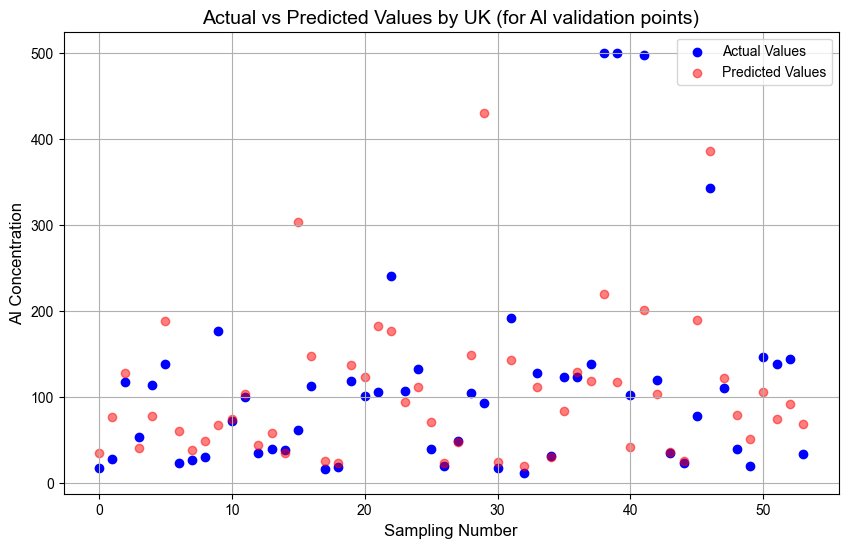

In [33]:
# 샘플링 순서에 따른 실제 값과 예측 값 비교
plt.figure(figsize=(10, 6))

# 테스트 데이터에 대한 샘플 순서 번호 생성
observation_value = np.arange(len(y_val))

# 실제 값 플롯
plt.scatter(observation_value, y_val, label='Actual Values', color='blue')

# 예측 값 플롯
plt.scatter(observation_value, z_val_uk, label='Predicted Values', color='red', alpha=0.5)

plt.xlabel('Sampling Number', fontsize=12)
plt.ylabel('Al Concentration', fontsize=12)
plt.title('Actual vs Predicted Values by UK (for Al validation points)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# Fit and predict on test set coordinates (scaled data)
try:
    z_pred_test_uk, _ = uk_model.execute('points', coor_test[:, 0], coor_test[:, 1])

    # RMSE 및 R2 계산
    rmse_test_uk = np.sqrt(mean_squared_error(y_test, z_pred_test_uk))
    mae_test_uk = mean_absolute_error(y_test, z_pred_test_uk)
    r2_test_uk = r2_score(y_test, z_pred_test_uk)

    print(f"Test RMSE (Universal Kriging): {rmse_test_uk:.2f}")
    print(f"Test MAE (Universal Kriging): {mae_test_uk:.2f}")
    print(f"Test R2 (Universal Kriging): {r2_test_uk:.3f}")

except Exception as e:
    print(f"\nError during Universal Kriging prediction on test data: {e}")

Executing Universal Kriging...

Test RMSE (Universal Kriging): 59.76
Test MAE (Universal Kriging): 34.80
Test R2 (Universal Kriging): 0.755


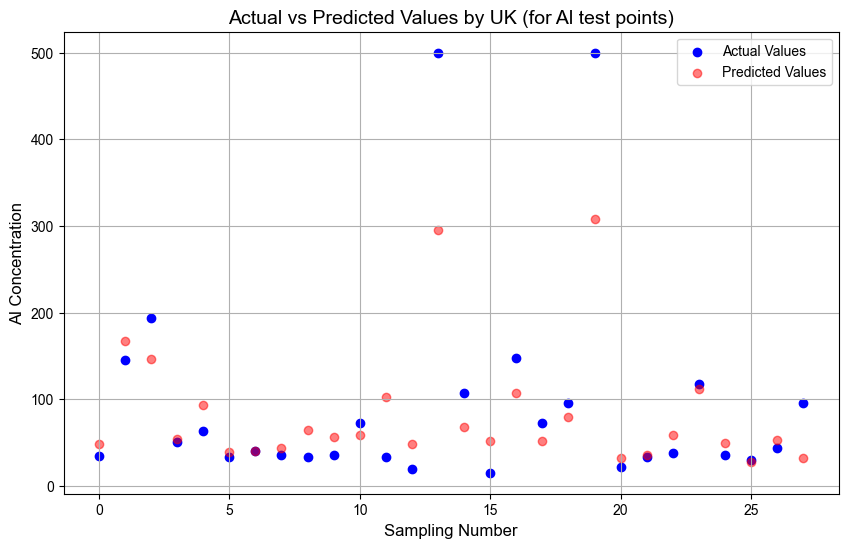

In [35]:
# 샘플링 순서에 따른 실제 값과 예측 값 비교
plt.figure(figsize=(10, 6))

# 검증 데이터에 대한 샘플 순서 번호 생성
observation_value = np.arange(len(y_test))

# 실제 값 플롯
plt.scatter(observation_value, y_test, label='Actual Values', color='blue')

# 예측 값 플롯
plt.scatter(observation_value, z_pred_test_uk, label='Predicted Values', color='red', alpha=0.5)

plt.xlabel('Sampling Number', fontsize=12)
plt.ylabel('Al Concentration', fontsize=12)
plt.title('Actual vs Predicted Values by UK (for Al test points)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [36]:
residual_ok = y_test - z_pred_test
residual_uk = y_test - z_pred_test_uk
X_test_df = pd.DataFrame(X_test)

# 3) 공간 산점도 (UTM 좌표 사용)
coords_x = df.loc[X_test_df.index, 'X_utm'].values
coords_y = df.loc[X_test_df.index, 'Y_utm'].values

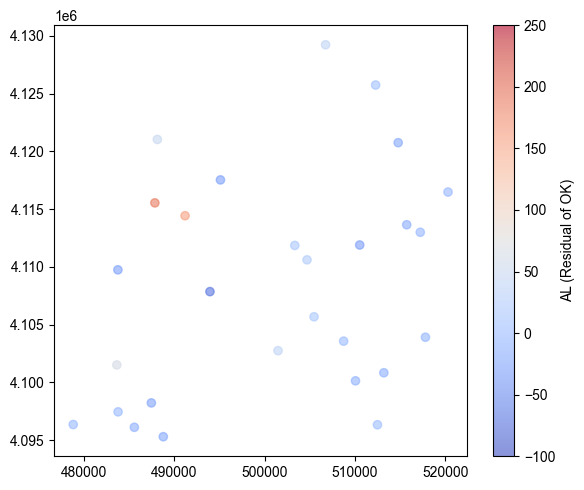

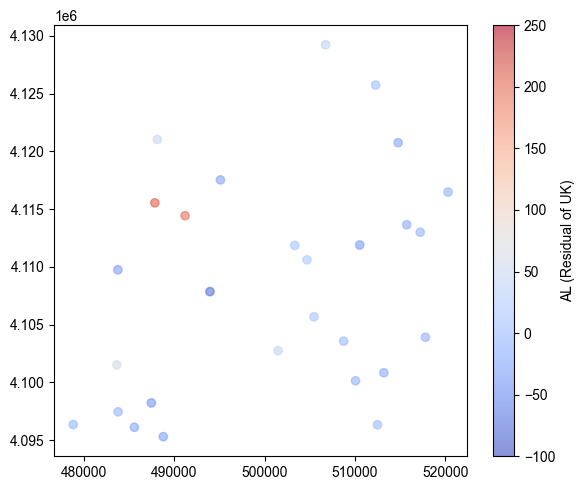

In [37]:
plt.figure(figsize=(6,5))
plt.scatter(coords_x, coords_y,
            c=residual_ok, cmap='coolwarm',
            marker='o', alpha=0.6, vmin=-100, vmax=250)
#plt.title('Residual of Ordinary Kriging (Test Set)')
plt.colorbar(label='AL (Residual of OK)')
#plt.xlabel('X_utm (m)')
#plt.ylabel('Y_utm (m)')
plt.tight_layout()
plt.savefig('Difference_Map_OK.png', dpi=300)
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(coords_x, coords_y,
            c=residual_uk, cmap='coolwarm',
            marker='o', alpha=0.6, vmin=-100, vmax=250)
#plt.title('Residual of Universal Kriging (Test Set)')
plt.colorbar(label='AL (Residual of UK)')
#plt.xlabel('X_utm (m)')
#plt.ylabel('Y_utm (m)')
plt.tight_layout()
plt.savefig('Difference_Map_UK.png', dpi=300)
plt.show()

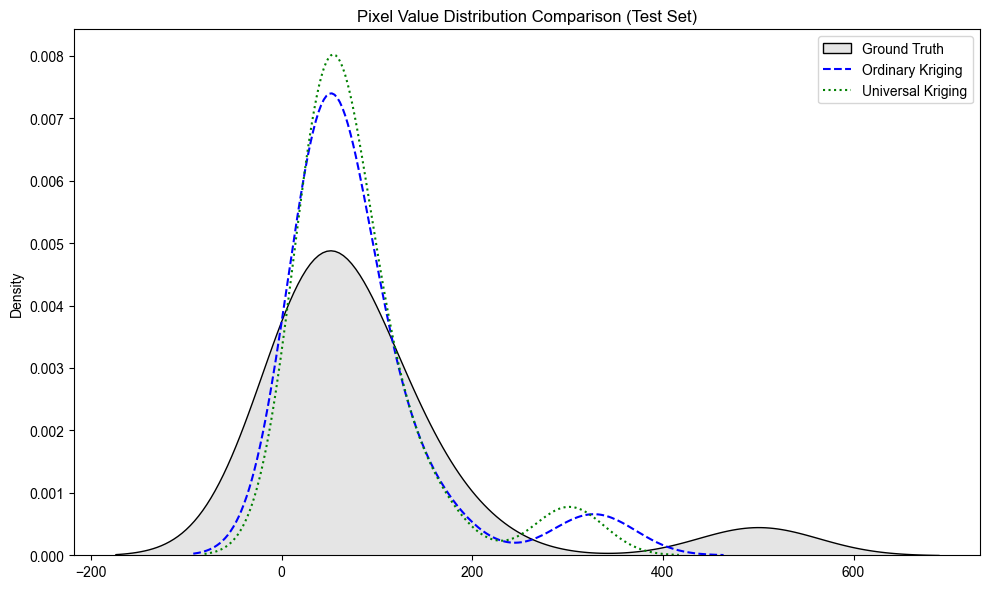

In [38]:
# 분포 비교 (Distribution Comparison)
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Ground Truth', color='black', fill=True, alpha=0.1)
sns.kdeplot(z_pred_test, label='Ordinary Kriging', color='blue', linestyle='--')
sns.kdeplot(z_pred_test_uk, label='Universal Kriging', color='green', linestyle=':')
plt.title('Pixel Value Distribution Comparison (Test Set)')
plt.legend()
plt.tight_layout()
# plt.savefig('Distribution_Comparison_GS.png')
plt.show()

In [39]:
data = {
    'Ground Truth': y_test,
    'Ordinary Kriging': z_pred_test,
    'Universal Kriging': z_pred_test_uk
}

df = pd.DataFrame(data)
df.to_csv('my_data.csv', index=False)